# Lab 8: Introduction to Deep Learning (Text)

This lab will provide an introduction to deep learning using one of the most popular libraries, Keras, and will focus on applying deep learning to text data. Also, we will look at how we can utilize word embeddings and will experiment with different models including LSTMs, which are commonly used for text prediction/classification tasks.

In [2]:
%pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, MaxPooling1D, Bidirectional, LSTM
from keras.layers import Embedding
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
%pip install gensim
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# function for plotting accuracy and loss curves 

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [6]:
# function for plotting confusion matrix

# source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Introduction to Keras

We will use Keras to load the first dataset for this lab which will consist of 25,000 movie reviews that are labeled with either 'positive' or 'negative' sentiment. See below for the full description of the data from https://keras.io/api/datasets/imdb/:

"This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words"."

For more information about Keras, take a look through the documentation for the library which also includes many code sample: https://keras.io 

#### 1.1 Import & Explore Data 

When loading the data, we will (1) set the seed for reproducibility, (2) set index_from = 3 - this is a word index offset saying to start assigning indexes to words starting with 3 since we want to reserve 0 for padding, 1 for the start of the sequence and 2 for unknown words and (3) specify to only keep the 20,000 most frequent words in the dataset.

In [7]:
# load the data

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(seed = 671, # for reproducibility
                                        index_from = 3, # word index offset, will use 0 for padding, 1 for the start of the sequence and 2 for unknown words
                                        num_words=20000) #  will only keep the 20000 most frequent words in the dataset

17464789/17464789 [==============================] - 0s 0us/step


In [8]:
# how many training/testing samples?
print("Number of training samples:", len(x_train))
print("Number of testing samples:", len(x_test))

Number of training samples: 25000
Number of testing samples: 25000


In [9]:
# how many positive/negative reviews in our training data?
pd.Series(y_train).value_counts() # equal distribution between them

0    12500
1    12500
dtype: int64

In [10]:
print(x_train[0]) # example training sample

[1, 591, 81, 24, 437, 241, 634, 7, 129, 113, 149, 14, 20, 43, 92, 262, 48, 294, 9, 7578, 8, 30, 2, 33, 4, 499, 7, 25, 1543, 3850, 48, 25, 942, 72, 13, 4465, 18, 142, 8, 593, 12, 115, 122, 13, 244, 24, 31, 7, 148, 84, 8, 570, 149, 6, 20, 173, 96, 143, 13, 210, 28, 8, 67, 12, 143, 8, 4, 130, 51, 6, 666, 1323, 81, 624, 6, 5260, 5, 140, 5, 2565, 6, 1513, 5, 106, 12, 2245, 230, 53, 441, 591, 81, 24, 437, 241, 634, 7, 129, 113, 149, 14, 20, 43, 92, 262, 48, 294, 9, 7578, 8, 30, 2, 33, 4, 499, 7, 25, 1543, 3850, 48, 25, 942, 72, 13, 4465, 18, 142, 8, 593, 12, 115, 122, 13, 244, 24, 31, 7, 148, 84, 8, 570, 149, 6, 20, 173, 96, 143, 13, 210, 28, 8, 67, 12, 143, 8, 4, 130, 51, 6, 666, 1323, 81, 624, 6, 5260, 5, 140, 5, 2565, 6, 1513, 5, 106, 12, 2245, 230, 53, 441]


To review, each one of the movie reviews is a list of indexes that map to words - these indexes/words are ordered with regards to their frequency in the dataset across all reviews. To obtain the actual words, we can do the following:

In [11]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

word_dictionary = keras.datasets.imdb.get_word_index()
word_dictionary = {word:(idx+3) for word,idx in word_dictionary.items()}
word_dictionary["<PAD>"] = 0
word_dictionary["<START>"] = 1
word_dictionary["<UNK>"] = 2
index_dictionary = {idx:word for word,idx in word_dictionary.items()}
print(' '.join(index_dictionary[id] for id in x_train[0] ))

1641221/1641221 [==============================] - 0s 0us/step
<START> please do not waste 2 hours of your life watching this movie just don't especially if someone is fortunate to be <UNK> at the side of you damn cheek if you ask me i waited for something to happen it never did i am not one of those people to stop watching a movie part way through i always have to see it through to the end what a huge mistake do yourself a favour and go and paint a wall and watch it dry far more entertaining please do not waste 2 hours of your life watching this movie just don't especially if someone is fortunate to be <UNK> at the side of you damn cheek if you ask me i waited for something to happen it never did i am not one of those people to stop watching a movie part way through i always have to see it through to the end what a huge mistake do yourself a favour and go and paint a wall and watch it dry far more entertaining


Using this approach, we see how we can re-generate the text of the review but with punctuation removed and all the text lowercased since the text was cleaned prior to us loading it in. Also, we see that words that are not in the top 20,000 most frequent words in our dataset are replaced with < UNK >. 

Next we will divide our testing data in half to create a validation set so that we can assess performance during training. Also, we must make each review the same length as the models will expect each sample to be of the same length. We will base this decision off of the average length of a review in our training data to make sure we do not cut off too much of the data for any one review while also assuring we do not introduce too much noise into the model. This strategy is referred to as padding.

In [12]:
# separate out a validation set from the test set 
x_val = x_test[0:12500]
y_val = y_test[0:12500]
x_test_sub = x_test[12500:]
y_test_sub = y_test[12500:]

In [13]:
print("Average length of a review:", np.mean([len(review) for review in x_train]))

Average length of a review: 238.71364


In [14]:
# pads the sequences by adding 0's to the end (if the sequence is shorter than 240 words)
x_train_pad = pad_sequences(x_train, padding='post', maxlen = 240) 
x_val_pad = pad_sequences(x_val, padding='post', maxlen = 240)
x_test_pad = pad_sequences(x_test_sub, padding='post', maxlen = 240)

#### 1.2 Model Fitting

Now that the data is ready, we can start fitting some models. First, we will fit a logistic regression model to serve as our baseline.

#### Logistic Regression

In [15]:
### YOUR CODE: fit a logistic regression model to the training data and assess performance on training, validation and test data
model = LogisticRegression()
model.fit(x_train_pad, y_train)
accuracy = model.

We see that logistic regression model does not do very well on this task. Let's see what we can do with deep learning models. 

#### Simple Neural Network

We will start with a basic model and build off of it. Our base model will be composed of the following:

1. An Embedding Layer (20000, 16, 240)

    - creates embeddings from our input sequences; they are initialized with random weights and will be learned during training
    - input_dim = size of vocabulary (20,000 in this case)
    - output_dim = embedding dimension (tunable hyperparameter)
    - input_length = length of padded sequences (240 in this case)

2. Flatten 
    - flattens the input to one dimension so that we can pass it on to a Dense layer
    
3. Dense (16, 'relu')
    - Fully connected layer of neurons
    - We can choose/tune the number of neurons (16 in this case) as well as the activation function ('relu' is a common choice)

4. Dense (1, 'sigmoid')
    - this serves as the output layer for making predictions
    - 'sigmoid' activation function is typically used in binary tasks such as this

Then we will compile our model, fit it to our training data (while also monitoring performance on the validation data) and will then assess its performance on the test data.

In [16]:
# create the model
model = Sequential()
model.add(Embedding(input_dim = 20000, output_dim = 16, input_length = 240)) 
model.add(Flatten()) 
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 240, 16)           320000    
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 16)                61456     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 381,473
Trainable params: 381,473
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# epochs = number of passes over the entire dataset
# batch size = number of samples used in each iteration/before each update is made to the weights
history = model.fit(x_train_pad, y_train, validation_data = (x_val_pad, y_val), epochs=5, batch_size=256)

Epoch 1/5
98/98 [==============================] - 3s 21ms/step - loss: 0.6208 - accuracy: 0.6495 - val_loss: 0.4113 - val_accuracy: 0.8327
Epoch 2/5
98/98 [==============================] - 2s 20ms/step - loss: 0.2733 - accuracy: 0.8942 - val_loss: 0.3012 - val_accuracy: 0.8731
Epoch 3/5
98/98 [==============================] - 2s 19ms/step - loss: 0.1468 - accuracy: 0.9540 - val_loss: 0.3056 - val_accuracy: 0.8757
Epoch 4/5
98/98 [==============================] - 2s 19ms/step - loss: 0.0778 - accuracy: 0.9809 - val_loss: 0.3362 - val_accuracy: 0.8679
Epoch 5/5
98/98 [==============================] - 3s 27ms/step - loss: 0.0386 - accuracy: 0.9939 - val_loss: 0.3648 - val_accuracy: 0.8680


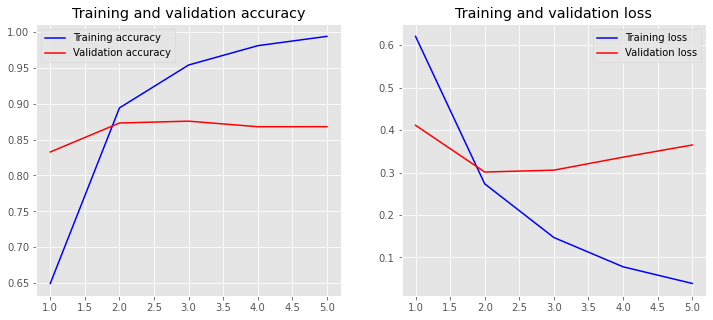

In [18]:
plot_history(history)

The accuracy and loss curves can help us understand if our model is experiencing overfitting or underfitting. In this case, we see that our model is overfitting since the training accuracy continues to increase across the epochs and the training loss continues to decrease while the validation accuracy remains relatively constant and the validation loss actually increases across the epochs. 

As we see that our model is overfitting, let's see if we can start to address it using two of the common approaches for doing so: (1) Dropout Layers and (2) Max Pooling. Dropout layers work by randomly setting inputs to 0 at a chosen rate - this way the model can not rely too heavily on any one input. Max Pooling works by reducing the dimensionality of the input which in turn reduces the number of parameters that need be trained - this makes the model less likely to find irrelevant patterns in the data. We will add these layers to our model but will keep everything else the same.

In [19]:
# create the model
model = Sequential()
model.add(Embedding(input_dim = 20000, output_dim = 16, input_length = 240)) 
model.add(MaxPooling1D()) # NEW
model.add(Dropout(0.5)) # NEW
model.add(Flatten())
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.5)) # NEW
model.add(Dense(1, activation='sigmoid')) 

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 240, 16)           320000    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 120, 16)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 120, 16)           0         
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                30736     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                      

In [20]:
history = model.fit(x_train_pad, y_train, validation_data = (x_val_pad, y_val), epochs=5, batch_size=256)

Epoch 1/5
98/98 [==============================] - 6s 56ms/step - loss: 0.6920 - accuracy: 0.5196 - val_loss: 0.6840 - val_accuracy: 0.6122
Epoch 2/5
98/98 [==============================] - 7s 71ms/step - loss: 0.5994 - accuracy: 0.6922 - val_loss: 0.4362 - val_accuracy: 0.8201
Epoch 3/5
98/98 [==============================] - 6s 63ms/step - loss: 0.3548 - accuracy: 0.8598 - val_loss: 0.3111 - val_accuracy: 0.8734
Epoch 4/5
98/98 [==============================] - 3s 34ms/step - loss: 0.2545 - accuracy: 0.9072 - val_loss: 0.2944 - val_accuracy: 0.8782
Epoch 5/5
98/98 [==============================] - 3s 34ms/step - loss: 0.1937 - accuracy: 0.9340 - val_loss: 0.2917 - val_accuracy: 0.8814


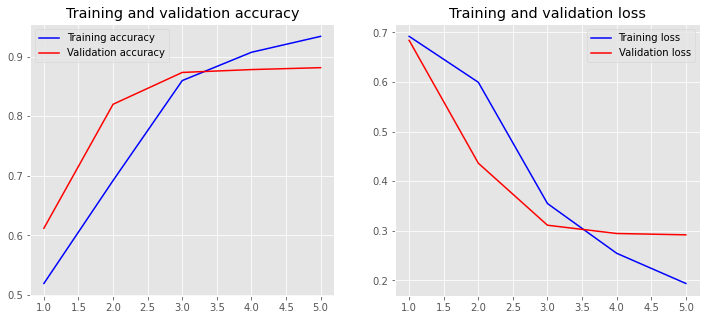

In [21]:
plot_history(history)

Comparing these plots to our previous ones, we see that the red line for validation data more closely follows the blue line for training data - this means we are experiencing less overfitting! Let's see how this model does on the testing data.

In [22]:
# testing results
loss, accuracy = model.evaluate(x_test_pad, y_test_sub, verbose=False)
print("Testing Loss {:.4f}, Testing Accuracy: {:.4f}".format(loss, accuracy))

Testing Loss 0.2866, Testing Accuracy: 0.8806


391/391 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[6237    0]
 [6263    0]]


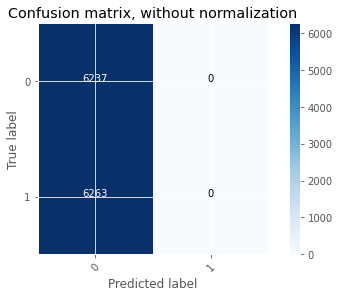

In [23]:
preds = model.predict(x_test_pad)
preds = np.argmax(preds,axis=1)

class_names = list(set(y_test_sub))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_sub, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

The diagonal of the confusion matrix shows the correct predictions (predicted label = true label) and the other values indicate how many incorrect predictions we made. This can be helpful for understanding what types of mistakes our model is making - here we see that our model is both misclassifying positive reviews as negative and vice versa at a similar rate. 

Overall, we saw how we can use techniques such as Dropout and Max Pooling to reduce overfitting and improve performance. Next, we will take a deeper dive into Word Embeddings.

### 2. Word Embeddings

Previously, our models were training their own word embeddings. However, there are many word embedding models that have been pre-trained on very large datasets and have shown promising results. Two of the most popular models are word2vec and GloVe. To demonstrate how they work, we will use word2vec as an example. Word2vec works by assigning each word a vector in space based on the context it is used within. Therefore, words that share similar "context" will be closer to one another in the space. 

Let's see some examples of how we can use word embeddings. We will be using a reduced/slimmed version of the GoogleNews word2vec embeddings as the full embeddings are very large.

In [26]:
# source: https://github.com/eyaler/word2vec-slim
from google.colab import files as colab_files
uploaded = colab_files.upload()
w2v_mod = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin", binary=True)

Saving ner_dataset.csv to ner_dataset.csv
Saving GoogleNews-vectors-negative300-SLIM.bin to GoogleNews-vectors-negative300-SLIM.bin
Saving glove.6B.100d.txt to glove.6B.100d.txt


In [29]:
# can find the cosine similarity between two words
print("Cosine similarity between burger and fries = {}".format(w2v_mod.similarity('burger', 'fries')))
print("Cosine similarity between burger and salad = {}".format(w2v_mod.similarity('burger', 'salad')))

Cosine similarity between burger and fries = 0.6894726753234863
Cosine similarity between burger and salad = 0.5826815366744995


We see that burger and fries are more similar to one another than burger and salad. We can also find the most similar words to a given word, such as 'pizza':

In [30]:
# what words are most similiar to pizza?
w2v_mod.most_similar(positive=['pizza'])

[('pizzas', 0.7863470315933228),
 ('Pizza', 0.6988078355789185),
 ('sandwich', 0.6840401887893677),
 ('burger', 0.6569692492485046),
 ('sandwiches', 0.6495091915130615),
 ('burrito', 0.6371643543243408),
 ('cheeseburger', 0.6192538738250732),
 ('pizzeria', 0.6176797151565552),
 ('hamburger', 0.6153676509857178),
 ('burgers', 0.6057732701301575)]

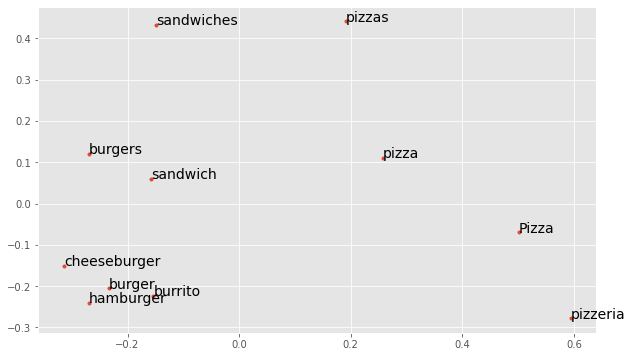

In [31]:
# nearest neighbor plot

# source: https://towardsdatascience.com/how-to-solve-analogies-with-word2vec-6ebaf2354009
def plot_data(orig_data, labels):
    pca = PCA(n_components=2) # use pca to reduce dimensional space to 2 for plotting
    data_pca = pca.fit_transform(orig_data)
    plt.figure(figsize=(10, 6))
    plt.plot(data_pca[:,0], data_pca[:,1], '.')
    for i in range(len(data_pca)):
        plt.annotate(labels[i], xy = data_pca[i], size=14)
    
chosen_word = 'pizza'
most_similar_words = [w[0] for w in w2v_mod.most_similar(positive=[chosen_word])]

words = [chosen_word] + most_similar_words
word_data = [w2v_mod[w] for w in words]
plot_data(word_data, words)

We see that we can plot words in space and that those closer together are considered to be more 'similar'. We can also perform analogies!

In [28]:
# equivalent to woman-man+king=???
w2v_mod.most_similar(positive=['pizzeria', 'king'], negative=['hamburger']) 

[('kings', 0.4986611306667328),
 ('prince', 0.4652000665664673),
 ('sultan', 0.4528241753578186),
 ('monarch', 0.4341375231742859),
 ('queen', 0.4278426468372345),
 ('ruler', 0.41494470834732056),
 ('princes', 0.4032747149467468),
 ('royal', 0.38960614800453186),
 ('palace', 0.3833213448524475),
 ('throne', 0.38071221113204956)]

In [ ]:
# plotting analogies

# source: https://towardsdatascience.com/how-to-solve-analogies-with-word2vec-6ebaf2354009

def plot_data(orig_data, labels):
    pca = PCA(n_components=2) # use pca to reduce dimensional space to 2 for plotting
    data_pca = pca.fit_transform(orig_data)
    plt.figure(figsize=(10, 6))
    plt.plot(data_pca[:,0], data_pca[:,1], '.')
    for i in range(len(data_pca)):
        plt.annotate(labels[i], xy = data_pca[i], size=14)
    for i in range(len(data_pca)//2):
        plt.annotate("",
                xy=data_pca[i],
                xytext=data_pca[i+len(data_pca)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3", color='black'))

wordsa = ['woman', 'man']
wordsb = ['queen', 'king']
labels = wordsa + wordsb
data = [w2v_mod[w] for w in labels]
plot_data(data, labels)

Looking at the plot, we see that woman and queen have a similar relationship to man and king. 

In [ ]:
### YOUR CODE: write code that is equivalent to the following analogy: bake-cook+cooking=???

In [ ]:
### YOUR CODE: write code that is equivalent to the following analogy: Michigan-Illinois+Springfield=???

Lastly, let's load in some GloVe embeddings to see how they compare to our word2vec embeddings from above. We will use some that were trained on Wikipedia text. For more information, see https://nlp.stanford.edu/projects/glove/

In [ ]:
# compare to GloVe Embeddings

# source: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

# convert to word2vec format
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# load the embeddings model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# revisit analogy
glove_model.most_similar(positive=['woman', 'king'], negative=['man'])

We see that the results are similar between the chosen word2vec and GloVe word embeddings but there are some slight differences in the results since the models were trained on different data sources and use different strategies to construct the embeddings.

Next, we will revisit the Named Entity Recogintion (NER) task from the sequences lab. We will show how we can  integrate pre-trained word embeddings and create one of the most commonly used models for language-based tasks, LSTMs.

### 3. Extending to Named Entity Recognition

For this part of the lab, we will revisit the data from the sequences lab and will create deep learning models to perform Named Entity Recognition (NER). To reiterate, the goal of NER is to label items into a set of predefined states/entities, such as an organizations, dates/times, geographical locations, etc. 

In [27]:
# load the data

# data source: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus
ner_dataset = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")
print(ner_dataset.shape)
ner_dataset.head()

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
# fill in NaN sentences
ner_dataset.fillna(method='ffill', inplace=True)
ner_dataset.head()

As we cannot pass string values into our model, we must pre-process the data and assign index values to both the words and tags.

In [ ]:
# source: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

# create vocabulary indexes for words
vocab = list(set(ner_dataset['Word'].to_list()))
idx2word = {idx:word for  idx, word in enumerate(vocab)}
word2idx = {word:idx for  idx, word in enumerate(vocab)}

# create indexes for our tags
tags = list(set(ner_dataset['Tag'].to_list()))
idx2tag = {idx:tag for  idx, tag in enumerate(tags)}
tag2idx = {tag:idx for  idx, tag in enumerate(tags)}

In [ ]:
# create new columns with mappings
ner_dataset['Word_idx'] = ner_dataset['Word'].map(word2idx)
ner_dataset['Tag_idx'] = ner_dataset['Tag'].map(tag2idx)
ner_dataset.head()

In [ ]:
# group sentence words together, each row will be a sentence 
sentences = ner_dataset.groupby(['Sentence #'],as_index=False
                    )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
sentences.head()

Similar to our code in the example above, we need to pad our sentences so that each is the same length. Then we will split our data into training, validaiton and test sets.

In [ ]:
# source: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

vocab_size = len(list(set(ner_dataset['Word'].to_list()))) # how many unique words?
num_tags = len(list(set(ner_dataset['Tag'].to_list()))) # how many tags?

sentences_list = sentences['Word_idx'].tolist() # get a list of each sentences word indexes
max_len = np.max([len(sentence) for sentence in sentences_list]) # use the max this time
pad_sentences = pad_sequences(sentences_list, maxlen=max_len, padding='post') # pad each sentence to the same length

tags = sentences['Tag_idx'].tolist() # get a list of the each sentences tag indexes
pad_tags = pad_sequences(tags, maxlen=max_len, padding='post', value=tag2idx["O"]) # default value of "O"
pad_tags = [to_categorical(i, num_classes=num_tags) for i in pad_tags] # conversion

In [ ]:
# split data into train and test sets
sentences_train, sentences_test, tags_train, tags_test = train_test_split(pad_sentences, pad_tags, 
                                                                        test_size=0.33, random_state=671)

In [ ]:
# separate out a validation set from the test set (roughly half in each)
sentences_val = sentences_test[0:7913]
tags_val = tags_test[0:7913]
sentences_test_sub = sentences_test[7913:]
tags_test_sub = tags_test[7913:]

#### 3.1 More advanced networks: LSTM

Now that our data is ready, we will create a simple long short-term memory (LSTM) model. LSTMs are commonly used for language-based tasks as they offer the advantage of processing the entire sequence at once since they have the ability to store information in "memory." As a result, they are able to propogate information throughout the network. However, contrary to RNNs, LSTMs use "gates" to prevent all information from getting passed through allowing for better control of the flow of information through the network. We will fit an LSTM both with and without pre-trained embeddings so we can compare the results.

As we have more than 2 tags, we must use a different activation function in our output layer and compiler. We will use 'softmax' as the activation function in the output layer, a common choice for classification tasks, and will use the loss strategy of 'categorical_crossentropy', the more general version of 'binary_crossentropy'.

When specifying the model, we will make the LSTM a Bidirectional layer meaning that it trains on both the original sequence and the sequence in reverse order. Also, we will add a dropout to the LSTM layer to help prevent against overfitting.

In [ ]:
# create the model, train embeddings in the model

model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2)))
model.add(Dense(num_tags, activation="softmax"))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# we will limit to 1 epoch as training will be slow with a large # of parameters to train
history = model.fit(sentences_train, np.array(tags_train), validation_data = (sentences_val, np.array(tags_val)),
                                                                    batch_size = 256, epochs = 1)

In [ ]:
# explore results on test data
loss, accuracy = model.evaluate(sentences_test_sub, np.array(tags_test_sub), verbose=False)
print("Testing Loss {:.4f}, Testing Accuracy: {:.4f}".format(loss, accuracy))

#### 3.2 Integrate Pre-Trained Word Embeddings into Model

Next, let's integrate the pre-trained word embeddings to see how they impact model performance. To do so, we must create an embeddings matrix using the data.

In [ ]:
# source: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74
# gensim 4.0 + has different api than in the post

embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in word2idx.items():
    if i >= vocab_size:
        continue
    if word in w2v_mod.key_to_index.keys():
        embedding_matrix[i] = w2v_mod.get_vector(word)

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=300, weights=[embedding_matrix], input_length=max_len))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2)))
model.add(Dense(num_tags, activation="softmax"))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# we will limit to 1 epoch as training will be slow with a large # of parameters to train
history = model.fit(sentences_train, np.array(tags_train), validation_data = (sentences_val, np.array(tags_val)),
                                                                    batch_size = 256, epochs = 1)

In [ ]:
# explore results on test data
loss, accuracy = model.evaluate(sentences_test_sub, np.array(tags_test_sub), verbose=False)
print("Testing Loss {:.4f}, Testing Accuracy: {:.4f}".format(loss, accuracy))

We see that the model does slightly better with pre-trained embeddings.

Next, it is your turn to revisit the movie reviews data from the first part of the lab and integrate the pre-trained embeddings. Feel free to play around with the model hyperparameters and add/remove layers as well. What model gets you the best performance?

In [ ]:
###YOUR CODE: implement a new model with the pre-trained embeddings for the movie reviews data
### NOTE: you will need to first re-create the embedding matrix using the movie reviews data